In [1]:
# import standards
import pandas as pd
import numpy as np
import re

# import visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker

# other
from prepare import collision_data
from explore import ttest_report, chi_test
from matplotlib.style import use; use('~/.matplotlib/gruvbox.mplstyle')

In [2]:
train, test = collision_data()
img = mpimg.imread('sa.png')

## Time

In [3]:
# create counts of vehicles with injuries reported grouped by hours
hourly_injured = train[train.injury_class == 1].set_index('crash_date').resample('H').count().crash_id
# create counts of vehicles with injuries reported grouped by hours
hourly_uninjured = train[train.injury_class == 0].set_index('crash_date').resample('H').count().crash_id
# set upper bound for injuries reported
q1, q3 = hourly_injured.quantile([0.25, 0.75])
iqr = q3 - q1
excess_injured = iqr + 1.5 * q3

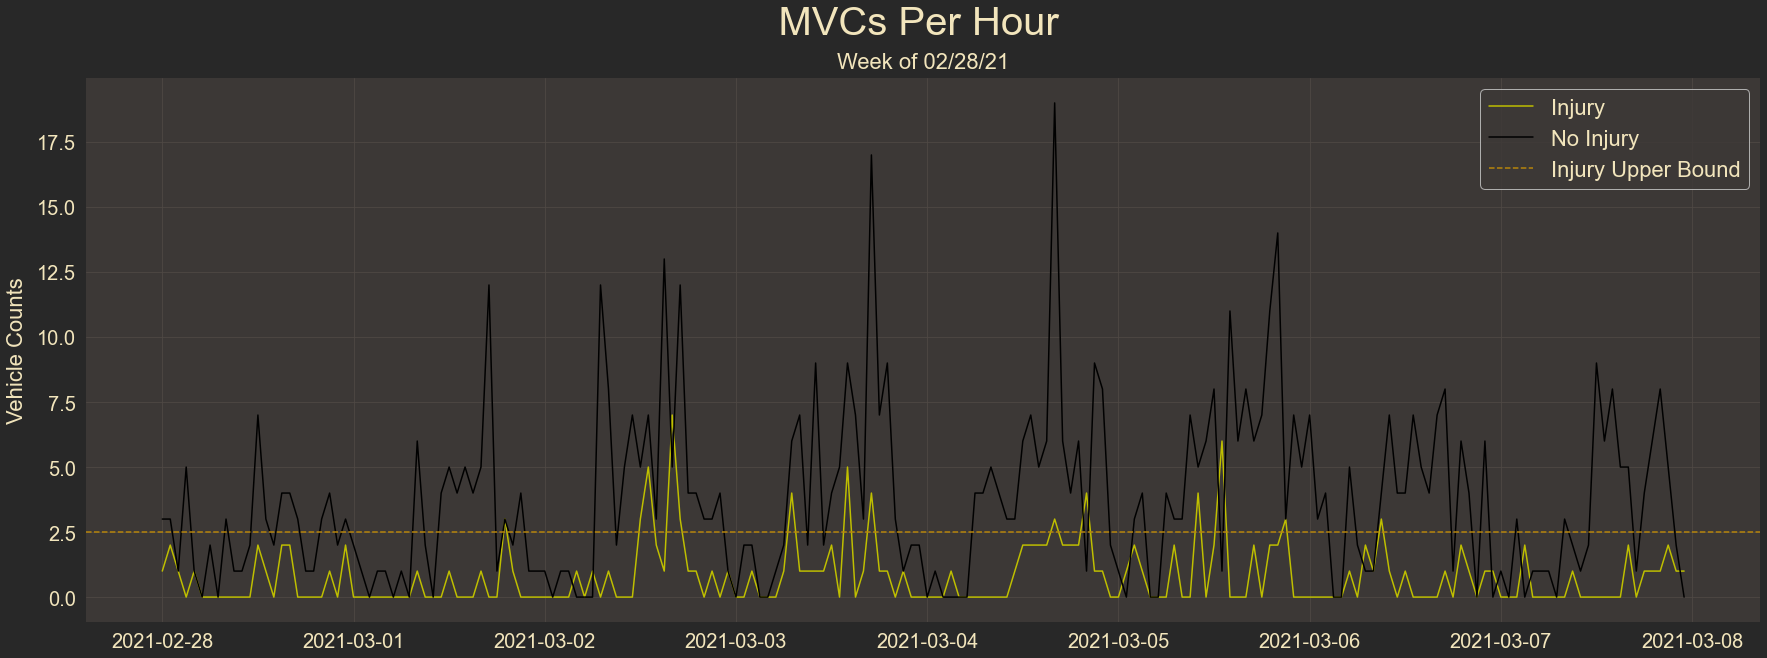

In [4]:
# set ax
fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(hourly_injured['2021-02-28':'2021-03-07'], c='y', label='Injury')
ax.plot(hourly_uninjured['2021-02-28':'2021-03-07'], c='k', label='No Injury')
ax.axhline(excess_injured, c='darkgoldenrod', linestyle='dashed', label='Injury Upper Bound')
ax.tick_params(labelsize=20, pad=10)
ax.set_ylabel('Vehicle Counts', fontsize=22, labelpad=10)
plt.suptitle('    MVCs Per Hour', fontsize=40)
plt.title('Week of 02/28/21', fontsize=22, pad=10)
plt.legend(fontsize=22, frameon=True)
plt.show()

In [5]:
train['day_num'] = train.set_index('crash_date').index.day_of_week

In [6]:
crash_hour_mean = train.groupby(['day_num', 'crash_hour']).mean().injury_class
q1, q3 = crash_hour_mean.quantile([0.25, 0.75])
iqr = q3 - q1
upper = iqr + 1.5 * q3

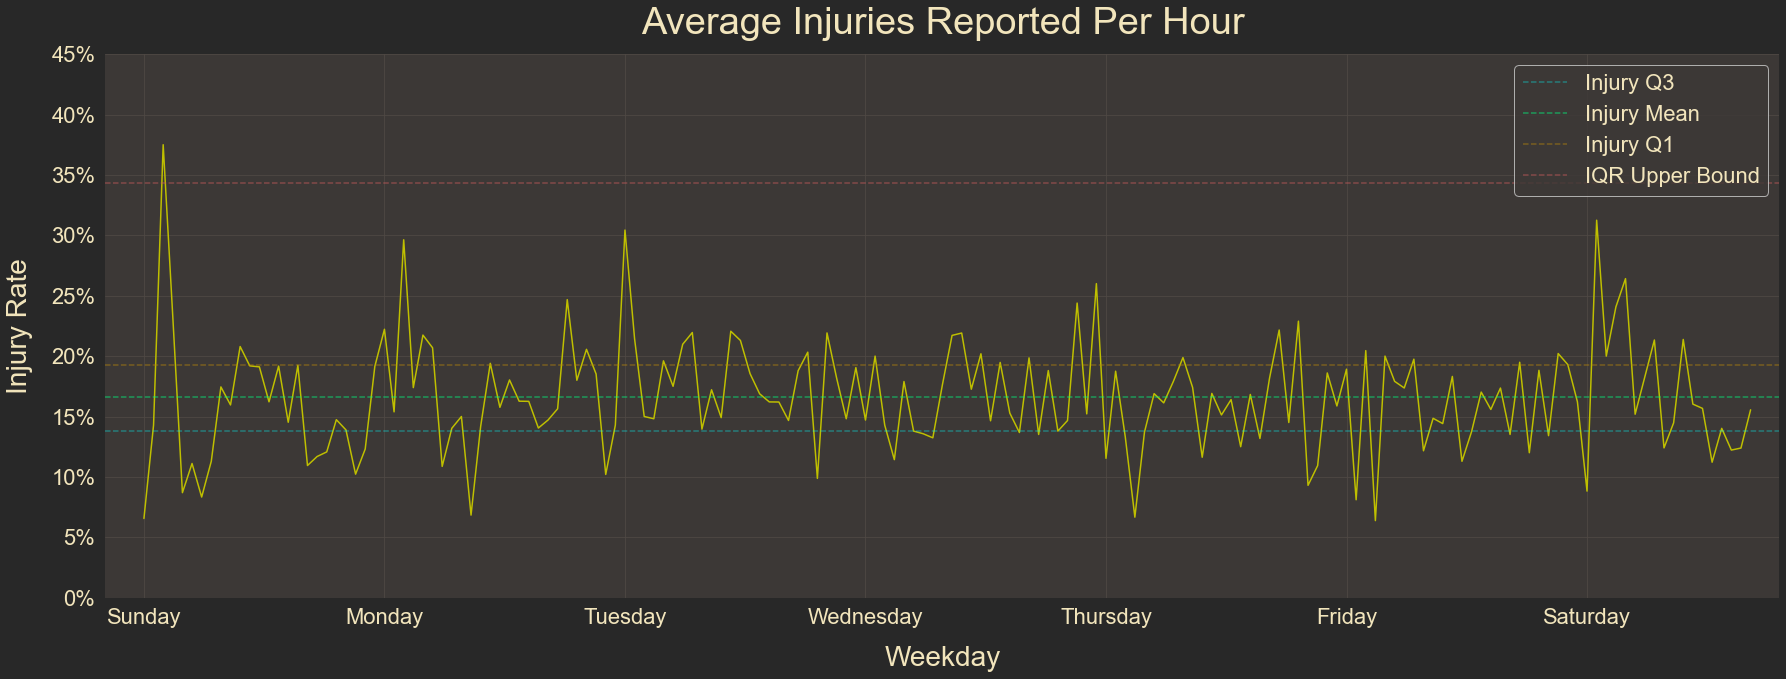

In [7]:
# create figure and set dimensions
fig, ax = plt.subplots(figsize=(30,10))
# plot average injuries per hour
crash_hour_mean.plot(ax=ax, c='y', label='')
# plot q1, mean, q3, and iqr upper for injuries
ax.axhline(q1, linestyle='dashed', c='cyan', alpha=0.35, label='Injury Q3')
ax.axhline(crash_hour_mean.mean(), linestyle='dashed', c='springgreen', alpha=0.5, label='Injury Mean')
ax.axhline(q3, linestyle='dashed', c='darkgoldenrod', alpha=0.5, label='Injury Q1')
ax.axhline(upper, linestyle='dashed', c='indianred', alpha=0.5, label='IQR Upper Bound')
# set axis labels
ax.set_xlabel('Weekday', fontsize=28, labelpad=18)
ax.set_ylabel('Injury Rate', fontsize=28, labelpad=18)
# define tick params and labels
ax.tick_params(labelsize=22, pad=10)
ax.set_xticklabels(['', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', '', ''])
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, 0))
# set limits for formatting
ax.set_xlim(xmin=-4, xmax=170)
ax.set_ylim(ymin=0, ymax=.45)
# define appropraite legend params and title
ax.legend(fontsize=22, frameon=True, loc='upper right')
plt.title('Average Injuries Reported Per Hour', fontsize=38, pad=20)
# print it
plt.show()

## Time Breakdowns

#### Hourly

In [8]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['crash_hour']).crash_id.count() /
                    train.groupby(['crash_hour']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['crash_hour']).crash_id.count() /
                    train.groupby(['crash_hour']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)
injury_pct_df.columns = ['pct_inj', 'pct_not']

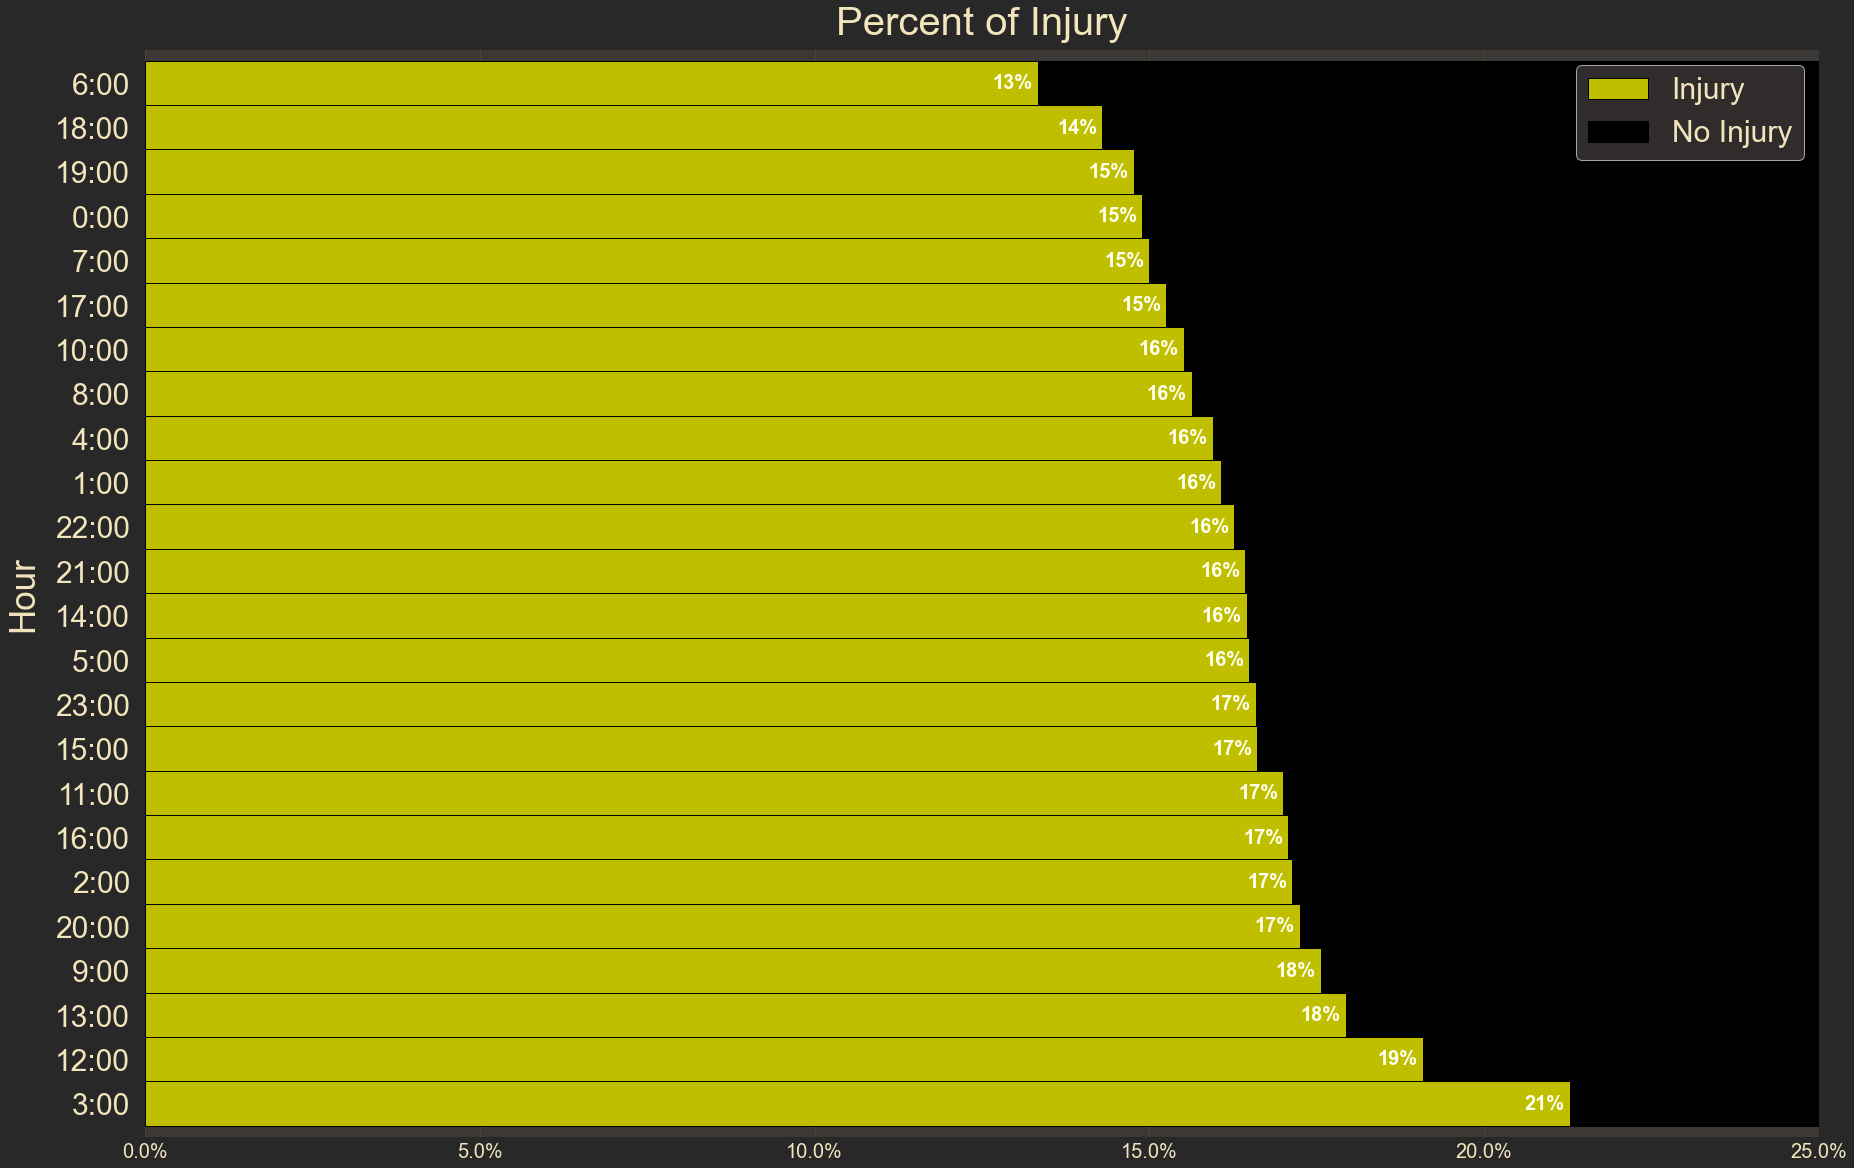

In [9]:
# set ax
fig, ax = plt.subplots(figsize=(30,20))
# create barplot
bars = injury_pct_df.sort_values('pct_inj', ascending=False).plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:24]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'\D+\d,\s\d{1,2}\D+(\d{1,2}).+', r'\1:00', str(x).title()) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=0.25)
# remove unneeded lavel
ax.set_ylabel('Hour', size=35, labelpad=15)
# define legend
ax.legend(labels=['Injury', 'No Injury'], fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury', fontsize=40, pad=15)
# make it rain
plt.show()

In [10]:
chi_test(train.crash_hour, train.injury_class)


    alpha: 0.05
    p-value: 0.1

    Due to p-value 0.1 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "crash_hour."
    


#### Day of Week

In [11]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['crash_day']).crash_id.count() /
                    train.groupby(['crash_day']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['crash_day']).crash_id.count() /
                    train.groupby(['crash_day']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)
injury_pct_df.columns = ['pct_inj', 'pct_not']

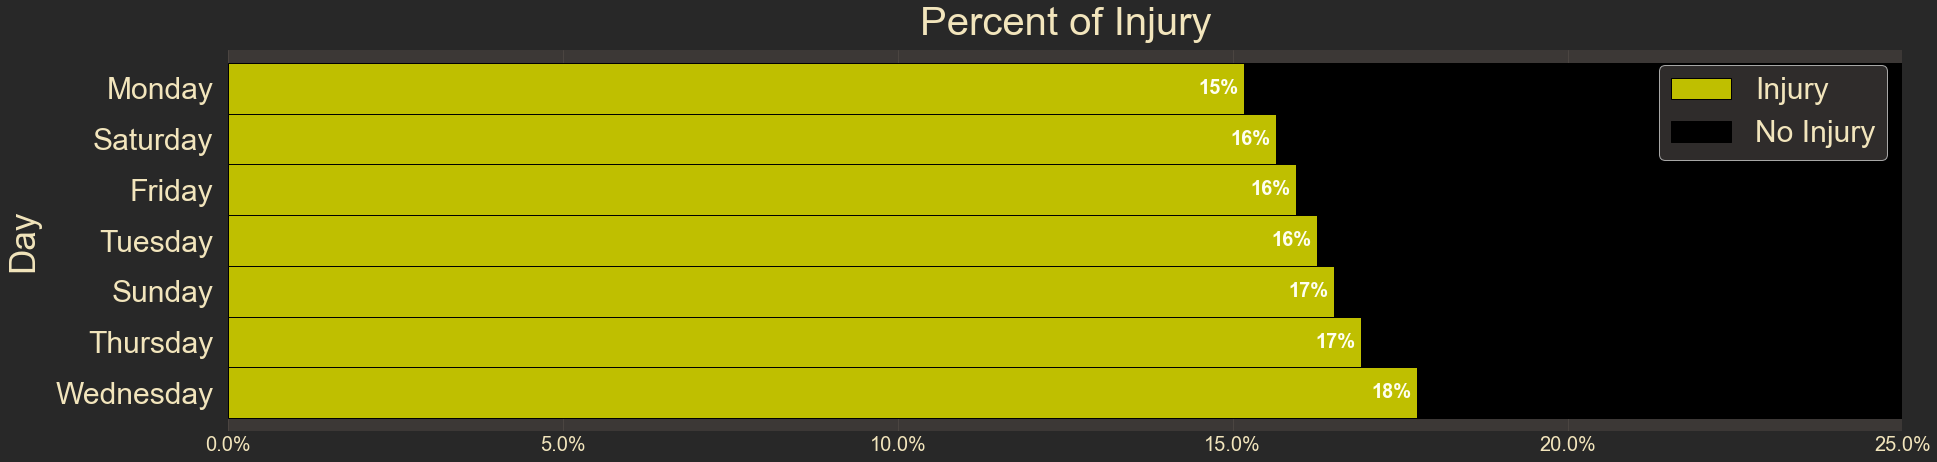

In [12]:
# set ax
fig, ax = plt.subplots(figsize=(30,7))
# create barplot
bars = injury_pct_df.sort_values('pct_inj', ascending=False).plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:7]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'.+\'(\w+).+', r'\1', str(x).title()) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=0.25)
# remove unneeded lavel
ax.set_ylabel('Day', size=35, labelpad=15)
# define legend
ax.legend(labels=['Injury', 'No Injury'], fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury', fontsize=40, pad=15)
# make it rain
plt.show()

In [13]:
chi_test(train.crash_day, train.injury_class)


    alpha: 0.05
    p-value: 0.1

    Due to p-value 0.1 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "crash_day."
    


## Events

#### Events: Spurs Home Games

In [14]:
# create list of dates for spurs home games
spurs_games = ['2021-02-01', '2021-02-03', '2021-02-08', '2021-02-09',
               '2021-02-27', '2021-03-01', '2021-03-02', '2021-03-04',
               '2021-03-12', '2021-03-22', '2021-03-24', '2021-03-25',
               '2021-03-27', '2021-03-29', '2021-03-31', '2021-04-01',
               '2021-04-03', '2021-04-05', '2021-04-16', '2021-04-21',
               '2021-04-22', '2021-05-02', '2021-05-10', '2021-05-15',
               '2021-05-16']
# create mask for indexs on spurs game days
train['spurs'] = train.apply(lambda row: True if any(date in str(row.crash_date) for date in spurs_games) and row.crash_hour > 14 else False, axis=1)

In [15]:
# set central points of AT&T center geocoords
att_lat = 29.426944
att_lon = -98.4375
# create maks for filtering location to nearby AT&T center
att_lat_1 = ((train.crash_latitude > att_lat * 0.999) &
              (train.crash_latitude < att_lat * 1.001))
att_lon_1 = ((train.crash_longitude > att_lon * 1.0005) &
              (train.crash_longitude < att_lon * 0.9995))
train['att_1'] = att_lat_1 & att_lon_1
# create maks for filtering location to slighty outside AT&T center
att_lat_2 = ((train.crash_latitude > att_lat * 0.998) &
              (train.crash_latitude < att_lat * 1.002) &
              ~(att_lat_1 & att_lon_1))
att_lon_2 = ((train.crash_longitude > att_lon * 1.0009) &
              (train.crash_longitude < att_lon * 0.9991) &
              ~(att_lat_1 & att_lon_1))
train['att_2'] = att_lat_2 & att_lon_2
# create mask for injury
injured = train.injury_class == 1

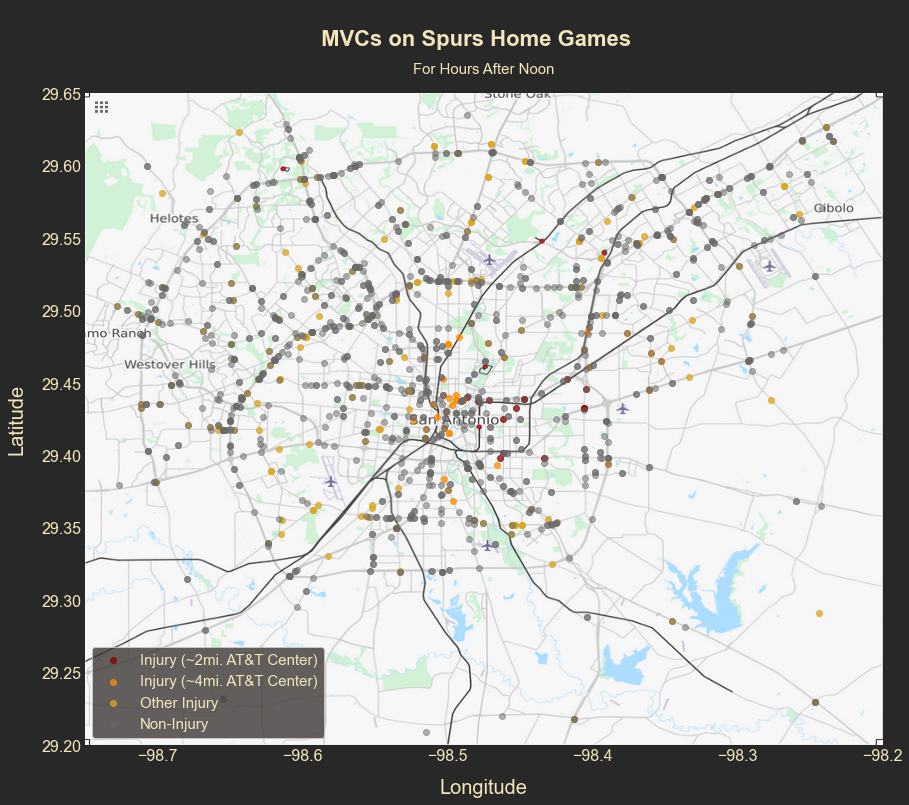

In [16]:
fig, ax = plt.subplots(figsize=(15,12))
ax.imshow(img, origin='upper', extent=(-98.75, -98.2, 29.2, 29.65))
ax.scatter(train[train.spurs & train.att_1 & injured].crash_longitude,
            train[train.spurs & train.att_1 & injured].crash_latitude,
            c='darkred', alpha=0.75, label='Injury (~2mi. AT&T Center)')
ax.scatter(train[train.spurs & train.att_1 & ~injured].crash_longitude,
            train[train.spurs & train.att_1 & ~injured].crash_latitude,
            c='dimgray', alpha=0.5)
ax.scatter(train[train.spurs & train.att_2 & injured].crash_longitude,
            train[train.spurs & train.att_2 & injured].crash_latitude,
            c='darkorange', alpha=0.75, label='Injury (~4mi. AT&T Center)')
ax.scatter(train[train.spurs & train.att_2 & ~injured].crash_longitude,
            train[train.spurs & train.att_2 & ~injured].crash_latitude,
            c='dimgray', alpha=0.5)
ax.scatter(train[train.spurs & ~(train.att_1) & ~(train.att_2) & injured].crash_longitude,
            train[train.spurs & ~(train.att_1) & ~(train.att_2) & injured].crash_latitude,
            c='goldenrod', alpha=0.75, label='Other Injury')
ax.scatter(train[train.spurs & ~(train.att_1) & ~(train.att_2) & ~injured].crash_longitude,
            train[train.spurs & ~(train.att_1) & ~(train.att_2) & ~injured].crash_latitude,
            c='dimgray', alpha=0.5, label='Non-Injury')

plt.xlabel('Longitude', fontsize=20, labelpad=15)
plt.ylabel('Latitude', fontsize=20, labelpad=15)
plt.xlim((-98.75, -98.2))
plt.ylim((29.2, 29.65))
plt.grid()
plt.legend(fontsize=15, frameon=True)
plt.suptitle('\n  MVCs on Spurs Home Games', size=22, weight='bold')
plt.title('For Hours After Noon', fontsize=15, pad=20)
plt.show()

In [17]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['spurs']).crash_id.count() /
                    train.groupby(['spurs']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['spurs']).crash_id.count() /
                    train.groupby(['spurs']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)

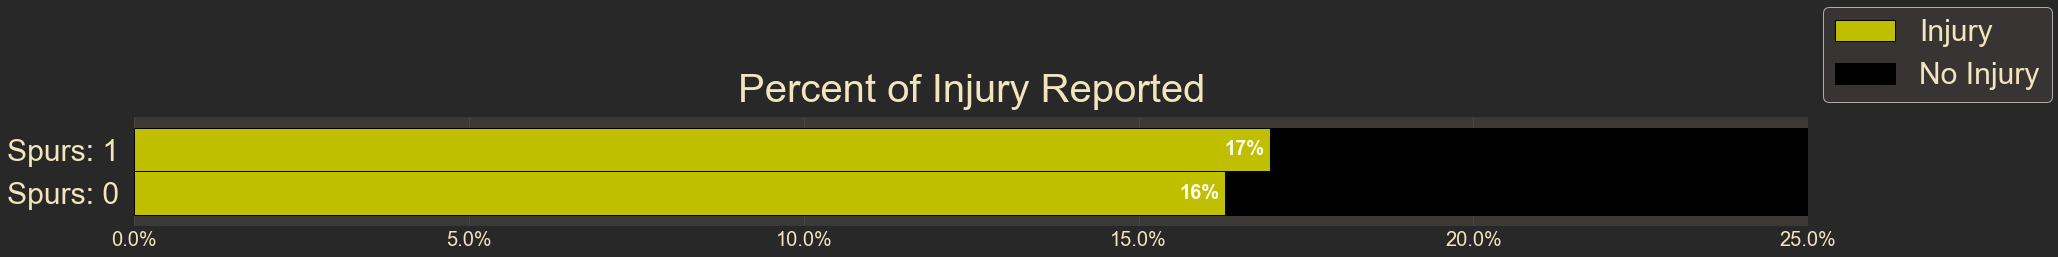

In [18]:
# set ax
fig, ax = plt.subplots(figsize=(30,2))
# create barplot
bars = injury_pct_df.plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:2]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'\D+\d\D+(\d)\D+', r'Spurs: \1', str(x)) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=0.25)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury Reported', fontsize=40, pad=15)
# make it rain
plt.show()

In [19]:
chi_test(train[train.spurs].att_1, train[train.spurs].injury_class)


    alpha: 0.05
    p-value: 1

    Due to p-value 1 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "att_1."
    


In [20]:
chi_test(train[train.spurs].att_2, train[train.spurs].injury_class)


    alpha: 0.05
    p-value: 0.9

    Due to p-value 0.9 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "att_2."
    


In [21]:
chi_test(train.spurs, train.injury_class)


    alpha: 0.05
    p-value: 0.5

    Due to p-value 0.5 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "spurs."
    


In [22]:
chi_test(train[train.spurs].fault_intoxication, train[train.spurs].injury_class)


    alpha: 0.05
    p-value: 0.2

    Due to p-value 0.2 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "fault_intoxication."
    


#### Events: Fiesta

In [23]:
# create mask for dates between fiesta
train['fiesta'] = train.crash_date.between('2021-06-17', '2021-06-27')

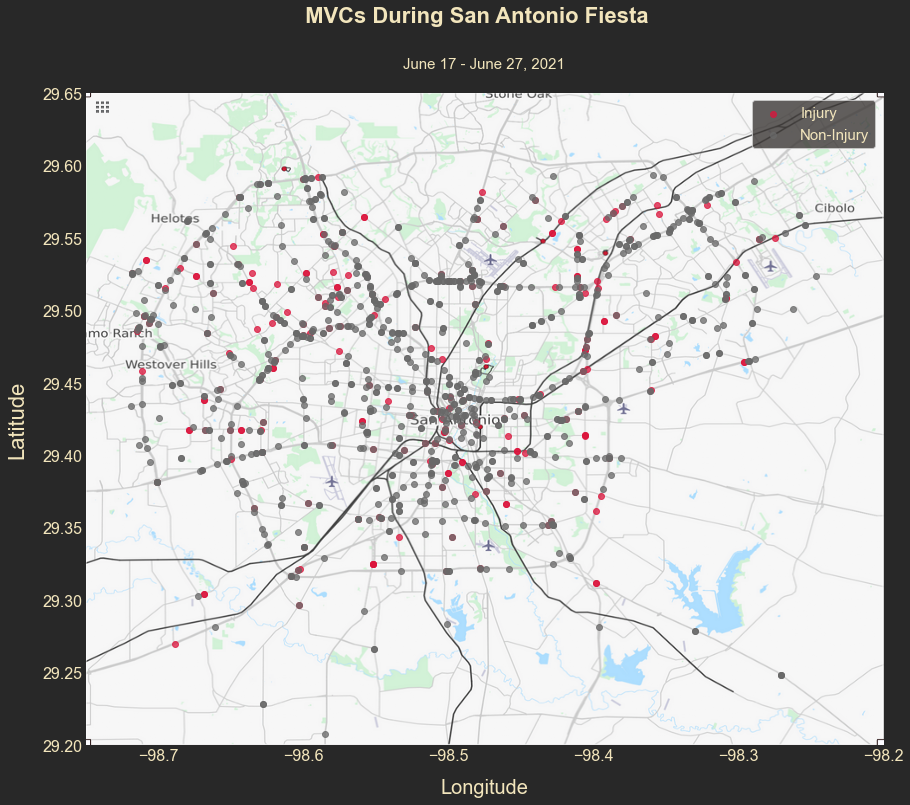

In [24]:
fig, ax = plt.subplots(figsize=(15,12))
ax.imshow(img, origin='upper',
          extent=(-98.75, -98.2, 29.2, 29.65))
plt.scatter(train[train.fiesta & injured].crash_longitude,
            train[train.fiesta & injured].crash_latitude,
            c='crimson', alpha=0.75, label='Injury')
plt.scatter(train[train.fiesta & ~injured].crash_longitude,
            train[train.fiesta & ~injured].crash_latitude,
            c='dimgray', alpha=0.75, label='Non-Injury')
plt.xlabel('Longitude', fontsize=20, labelpad=15)
plt.ylabel('Latitude', fontsize=22, labelpad=15)
plt.xlim((-98.75, -98.2))
plt.ylim((29.2, 29.65))
plt.grid()
plt.legend(fontsize=15, frameon=True)
plt.suptitle('  MVCs During San Antonio Fiesta', size=22, weight='bold')
plt.title('June 17 - June 27, 2021', fontsize=15, pad=25)
plt.show()

In [25]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['fiesta']).crash_id.count() /
                    train.groupby(['fiesta']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['fiesta']).crash_id.count() /
                    train.groupby(['fiesta']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)

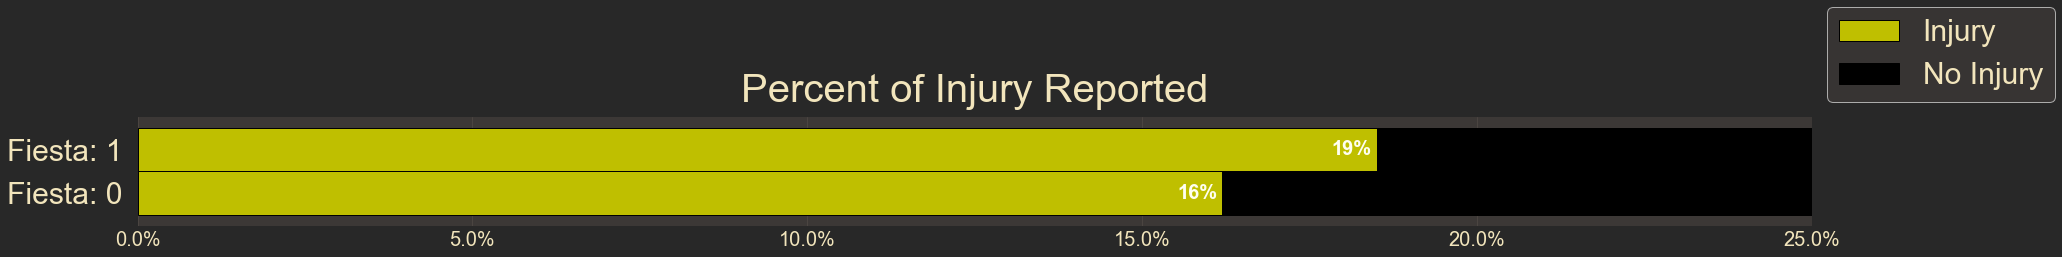

In [26]:
# set ax
fig, ax = plt.subplots(figsize=(30,2))
# create barplot
bars = injury_pct_df.plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:2]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'\D+\d\D+(\d)\D+', r'Fiesta: \1', str(x)) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=0.25)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury Reported', fontsize=40, pad=15)
# make it rain
plt.show()

In [27]:
chi_test(train.fiesta, train.injury_class)


    alpha: 0.05
    p-value: 0.04

    Due to p-value 0.04 being less than significance level 0.05, may reject the null hypothesis that "injury_class" is independent of "fiesta."
    


In [28]:
train['fiesta_intox'] = (train.fiesta) & (train.fault_intoxication)
chi_test(train.fiesta_intox, train.injury_class)


    alpha: 0.05
    p-value: 0.08

    Due to p-value 0.08 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "fiesta_intox."
    


In [29]:
chi_test(train.fiesta, train.fault_intoxication)


    alpha: 0.05
    p-value: 0.07

    Due to p-value 0.07 being more than significance level 0.05, fail to reject the null hypothesis that "fault_intoxication" is independent of "fiesta."
    


---
---

In [30]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['driver_age_bin', 'driver_male']).crash_id.count() /
                    train.groupby(['driver_age_bin', 'driver_male']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['driver_age_bin', 'driver_male']).crash_id.count() /
                    train.groupby(['driver_age_bin', 'driver_male']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)

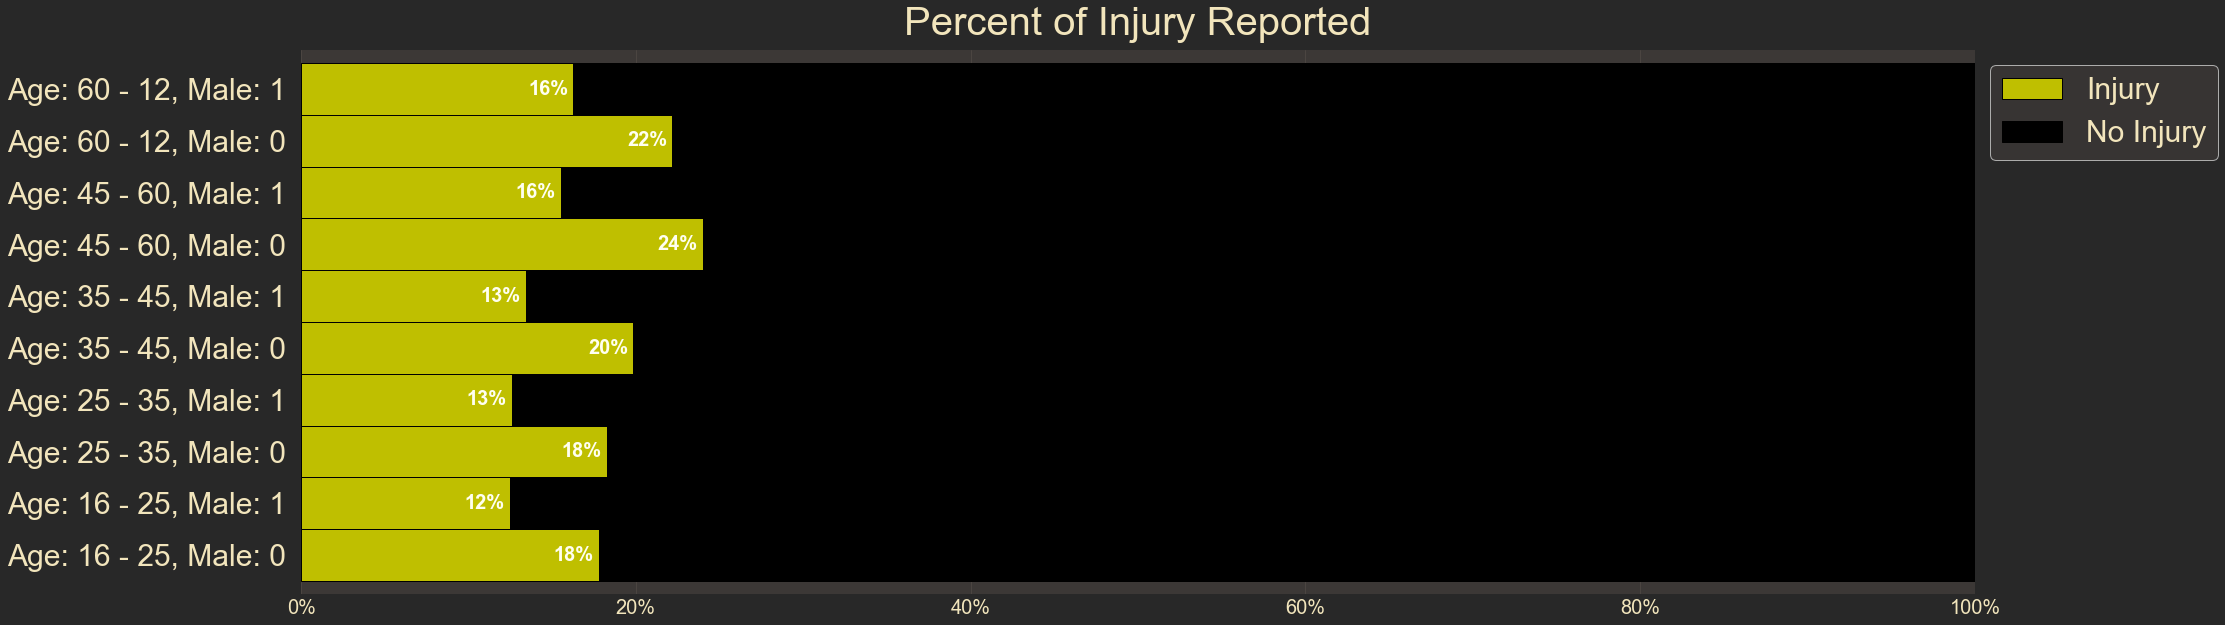

In [31]:
# set ax
fig, ax = plt.subplots(figsize=(30,10))
# create barplot
bars = injury_pct_df.plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:10]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'.+\(\((\d{2}),\s(\d{2}).+(\d).+', r'Age: \1 - \2, Male: \3', str(x)) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=1)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury Reported', fontsize=40, pad=15)
# make it rain
plt.show()

In [32]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['factors_road', 'damage_zone']).crash_id.count() /
                    train.groupby(['factors_road', 'damage_zone']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['factors_road', 'damage_zone']).crash_id.count() /
                    train.groupby(['factors_road', 'damage_zone']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)
injury_pct_df.columns = ['pct_inj', 'pct_not']

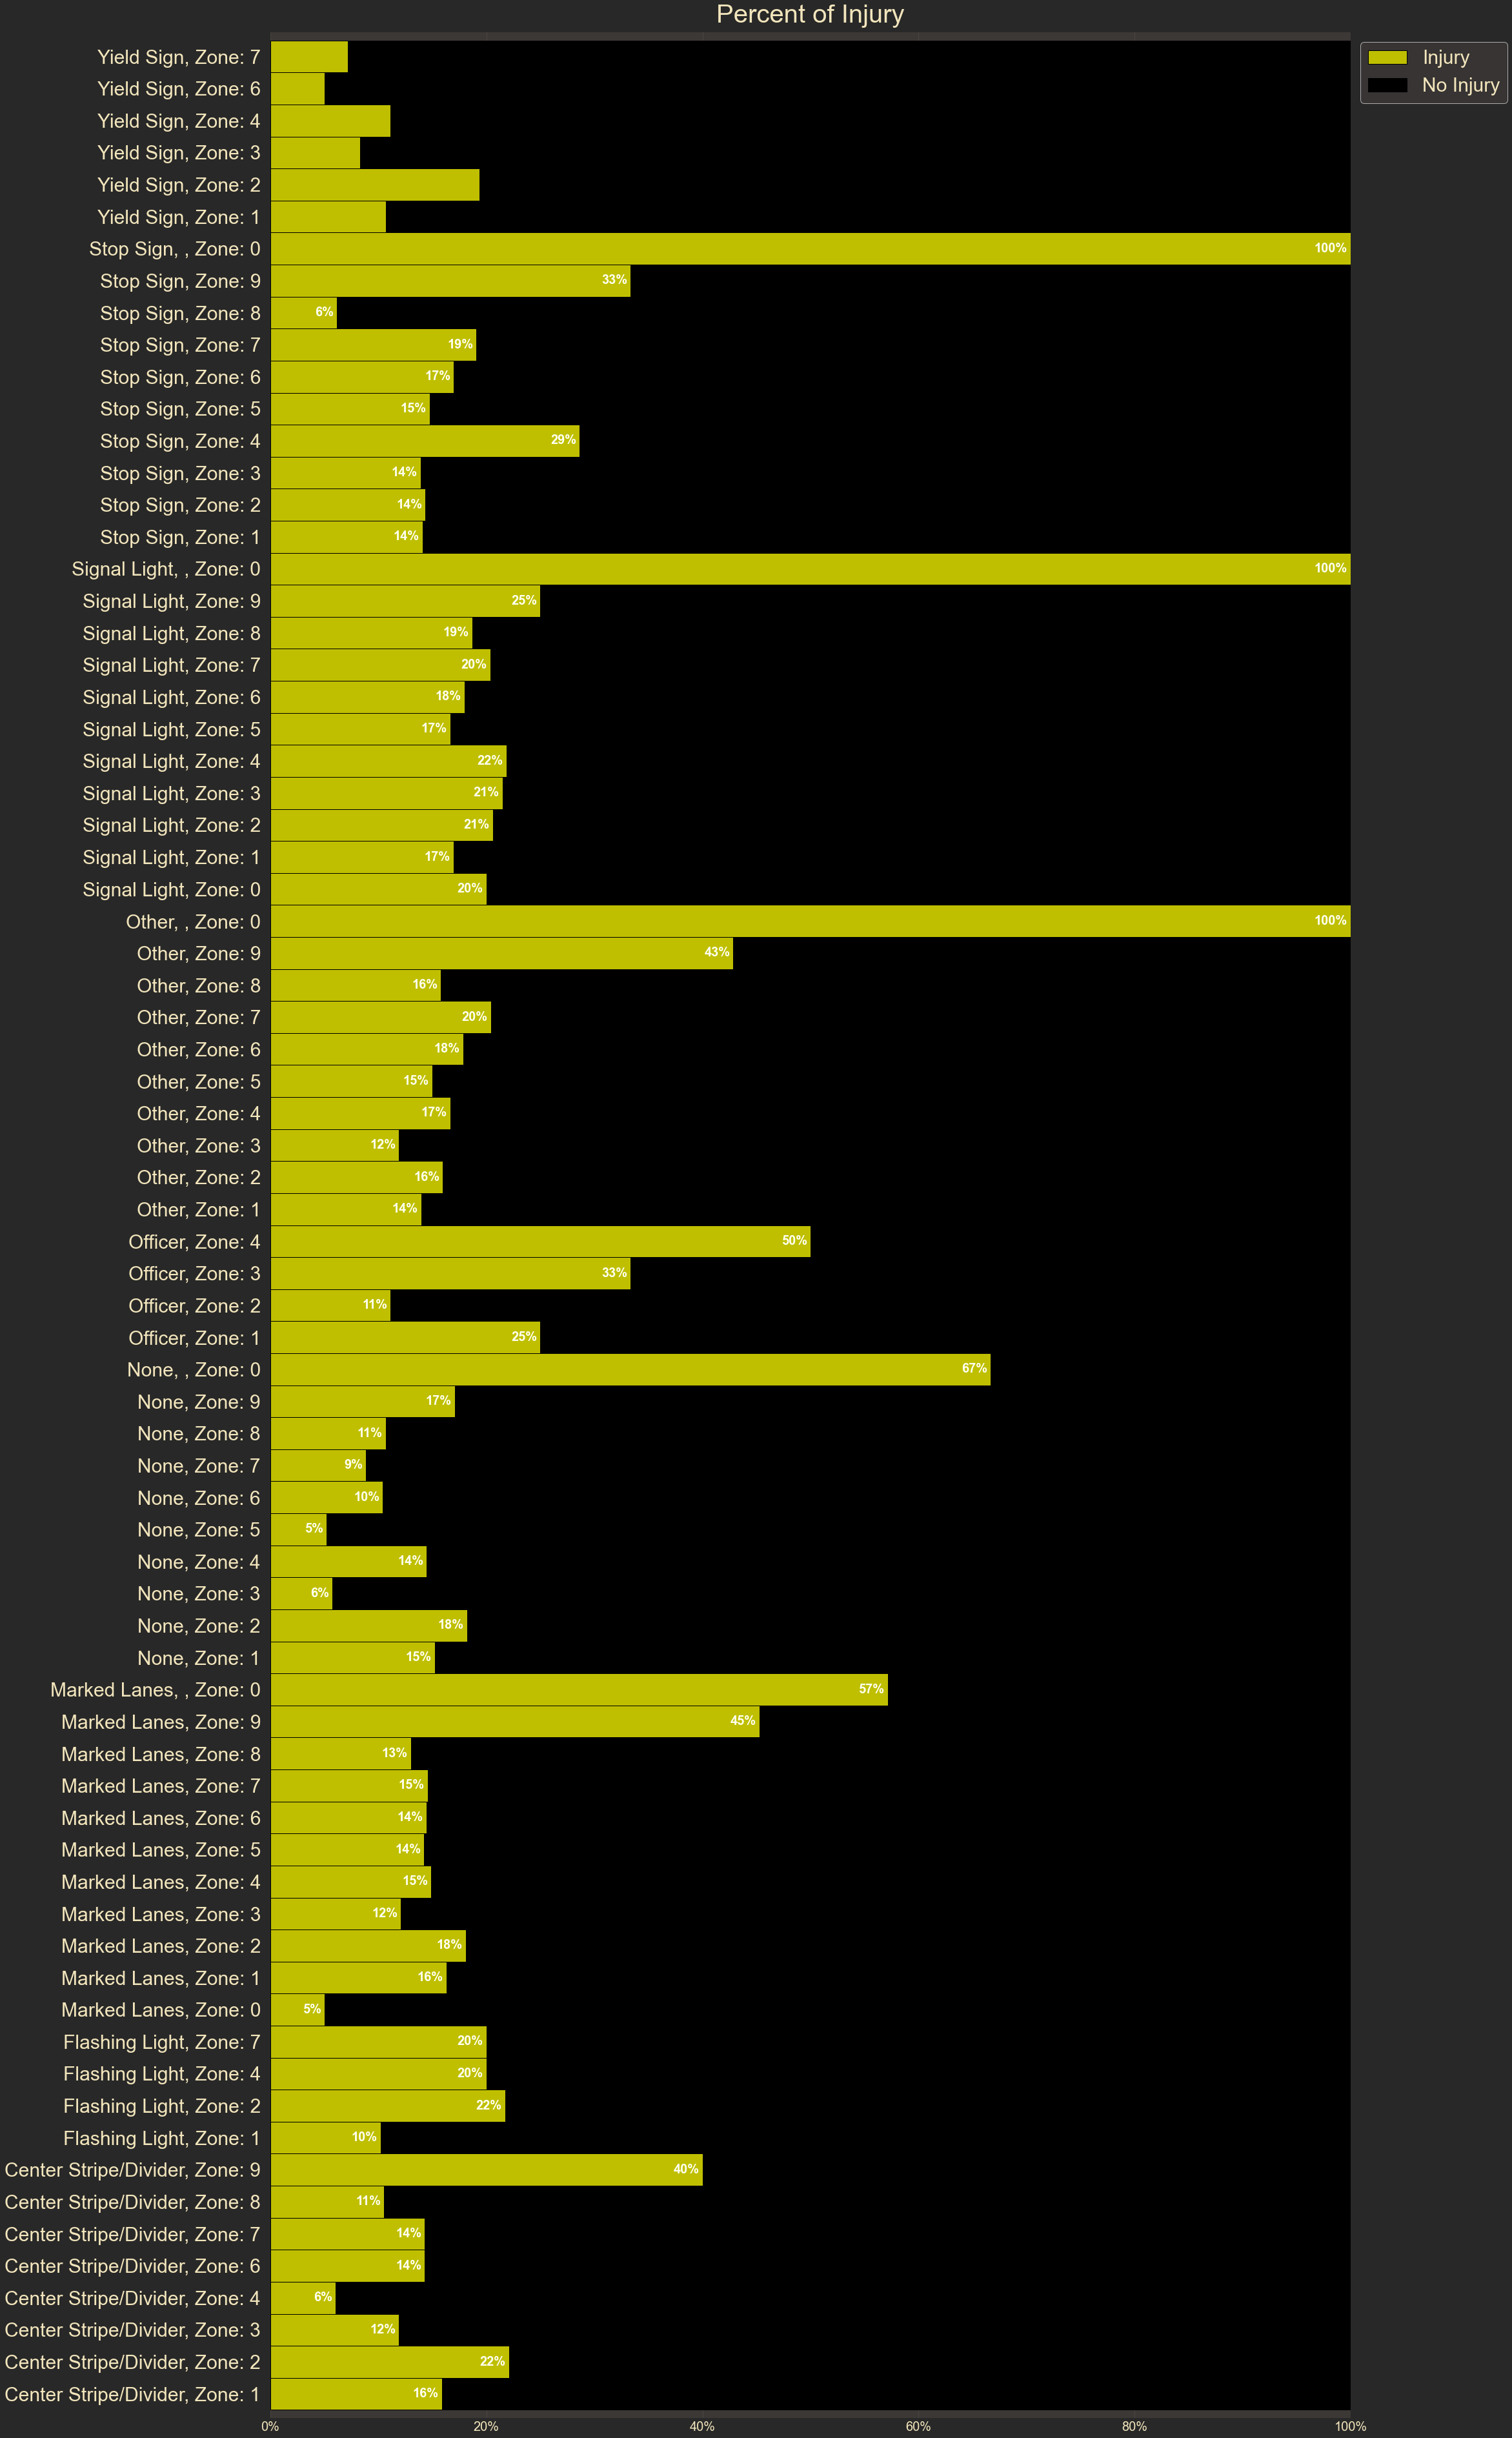

In [33]:
# set ax
fig, ax = plt.subplots(figsize=(30,68))
# create barplot
bars = injury_pct_df[injury_pct_df.pct_inj > 0].plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:68]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'.+\((.+[^,]).+(\d{1,2}).+', r'\1, Zone: \2', str(x).title()) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=1)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury', fontsize=40, pad=15)
# make it rain
plt.show()

In [34]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['damage_airbag', 'damage_zone']).crash_id.count() /
                    train.groupby(['damage_airbag', 'damage_zone']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['damage_airbag', 'damage_zone']).crash_id.count() /
                    train.groupby(['damage_airbag', 'damage_zone']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)
injury_pct_df.columns = ['pct_inj', 'pct_not']

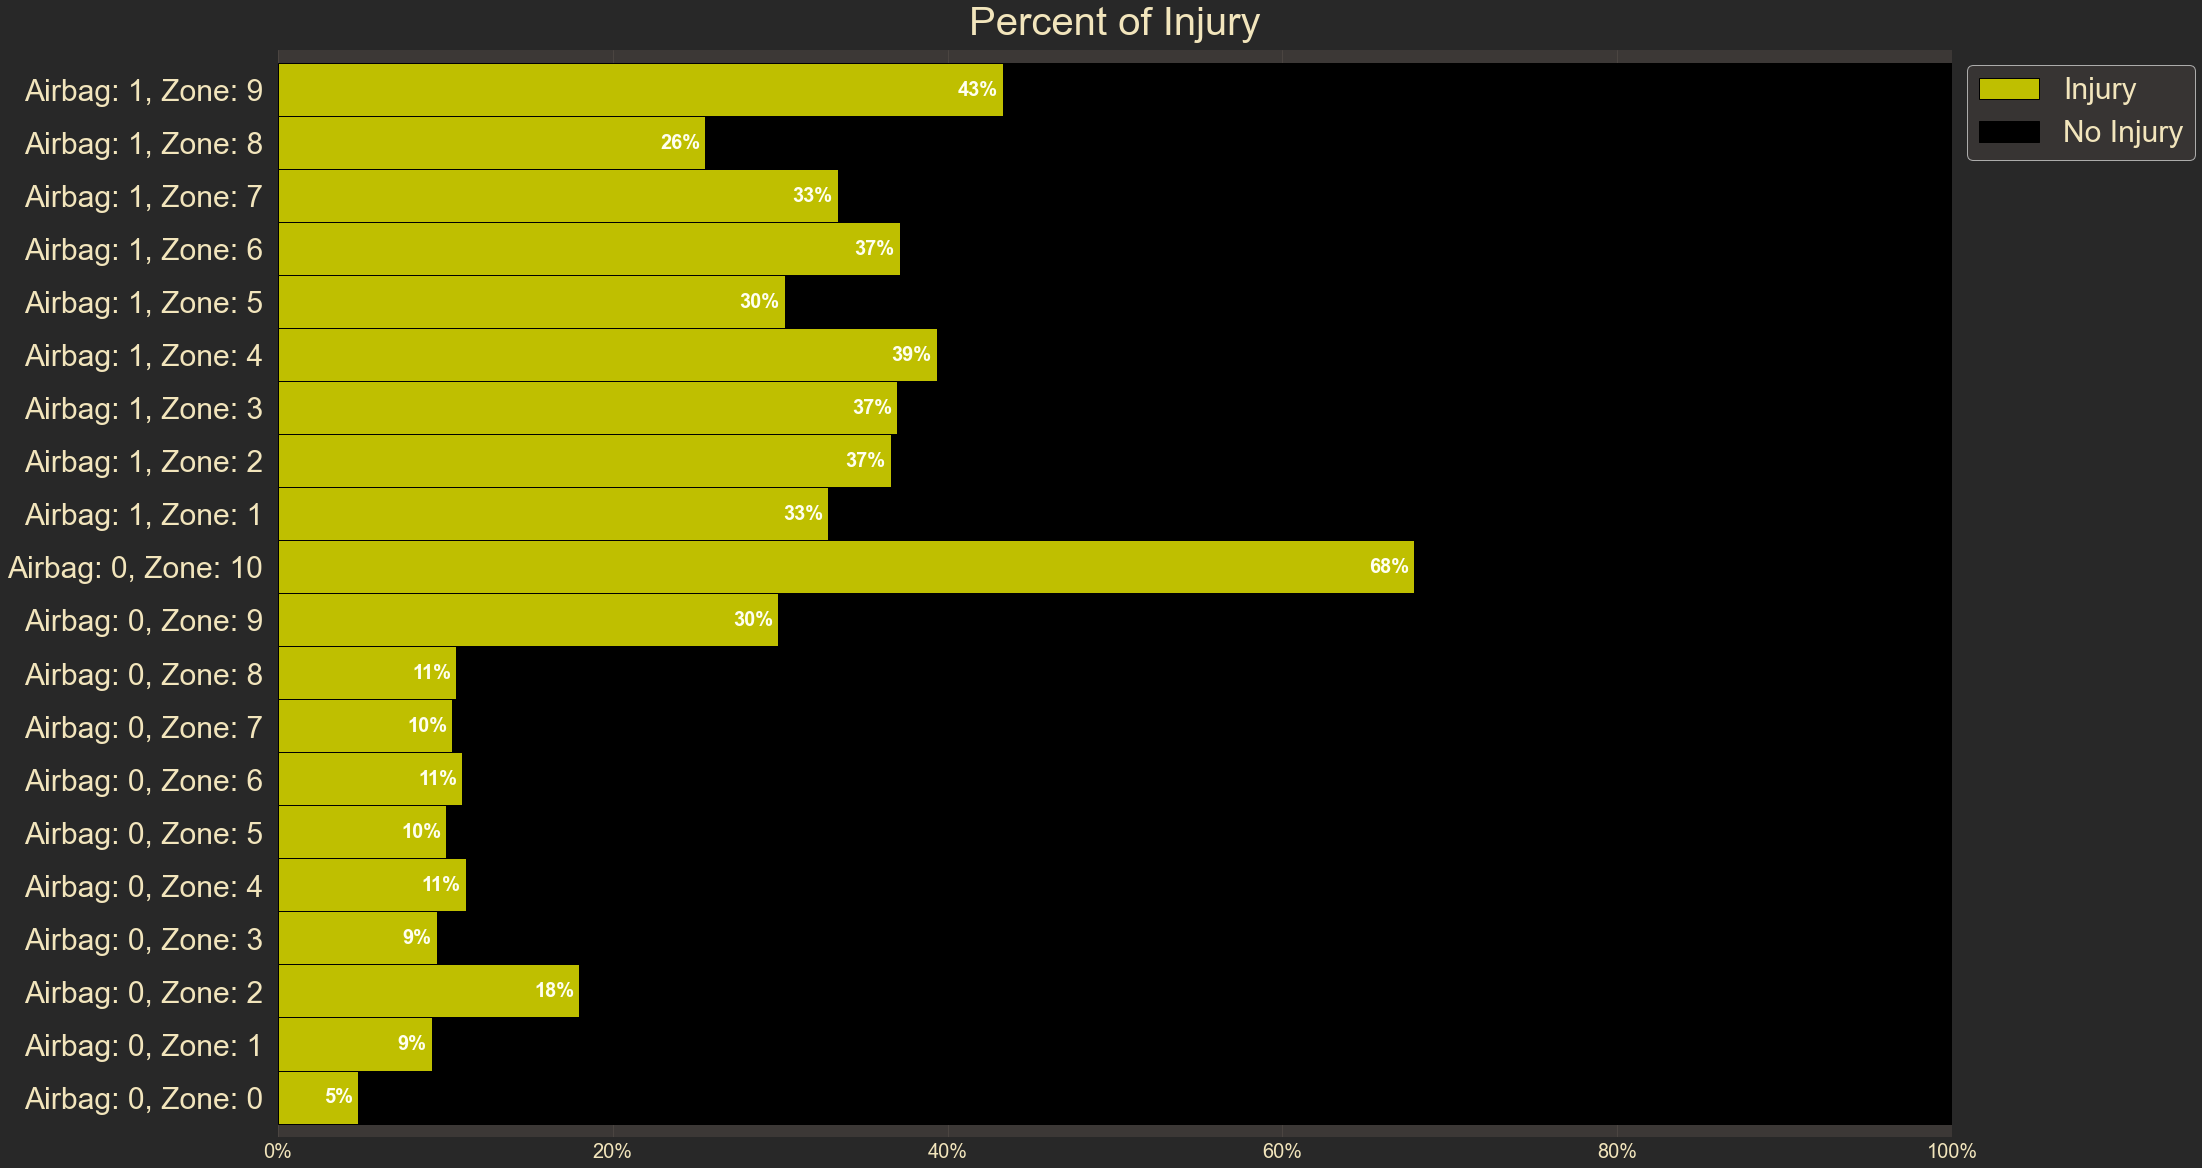

In [35]:
# set ax
fig, ax = plt.subplots(figsize=(30,20))
# create barplot
bars = injury_pct_df[injury_pct_df.pct_inj > 0].plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:20]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'.+\'\((\d)\D+(\d+).+', r'Airbag: \1, Zone: \2', str(x).title()) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=1)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury', fontsize=40, pad=15)
# make it rain
plt.show()

In [36]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['vehicle_year_bin', 'damage_zone']).crash_id.count() /
                    train.groupby(['vehicle_year_bin', 'damage_zone']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['vehicle_year_bin', 'damage_zone']).crash_id.count() /
                    train.groupby(['vehicle_year_bin', 'damage_zone']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)
injury_pct_df.columns = ['pct_inj', 'pct_not']

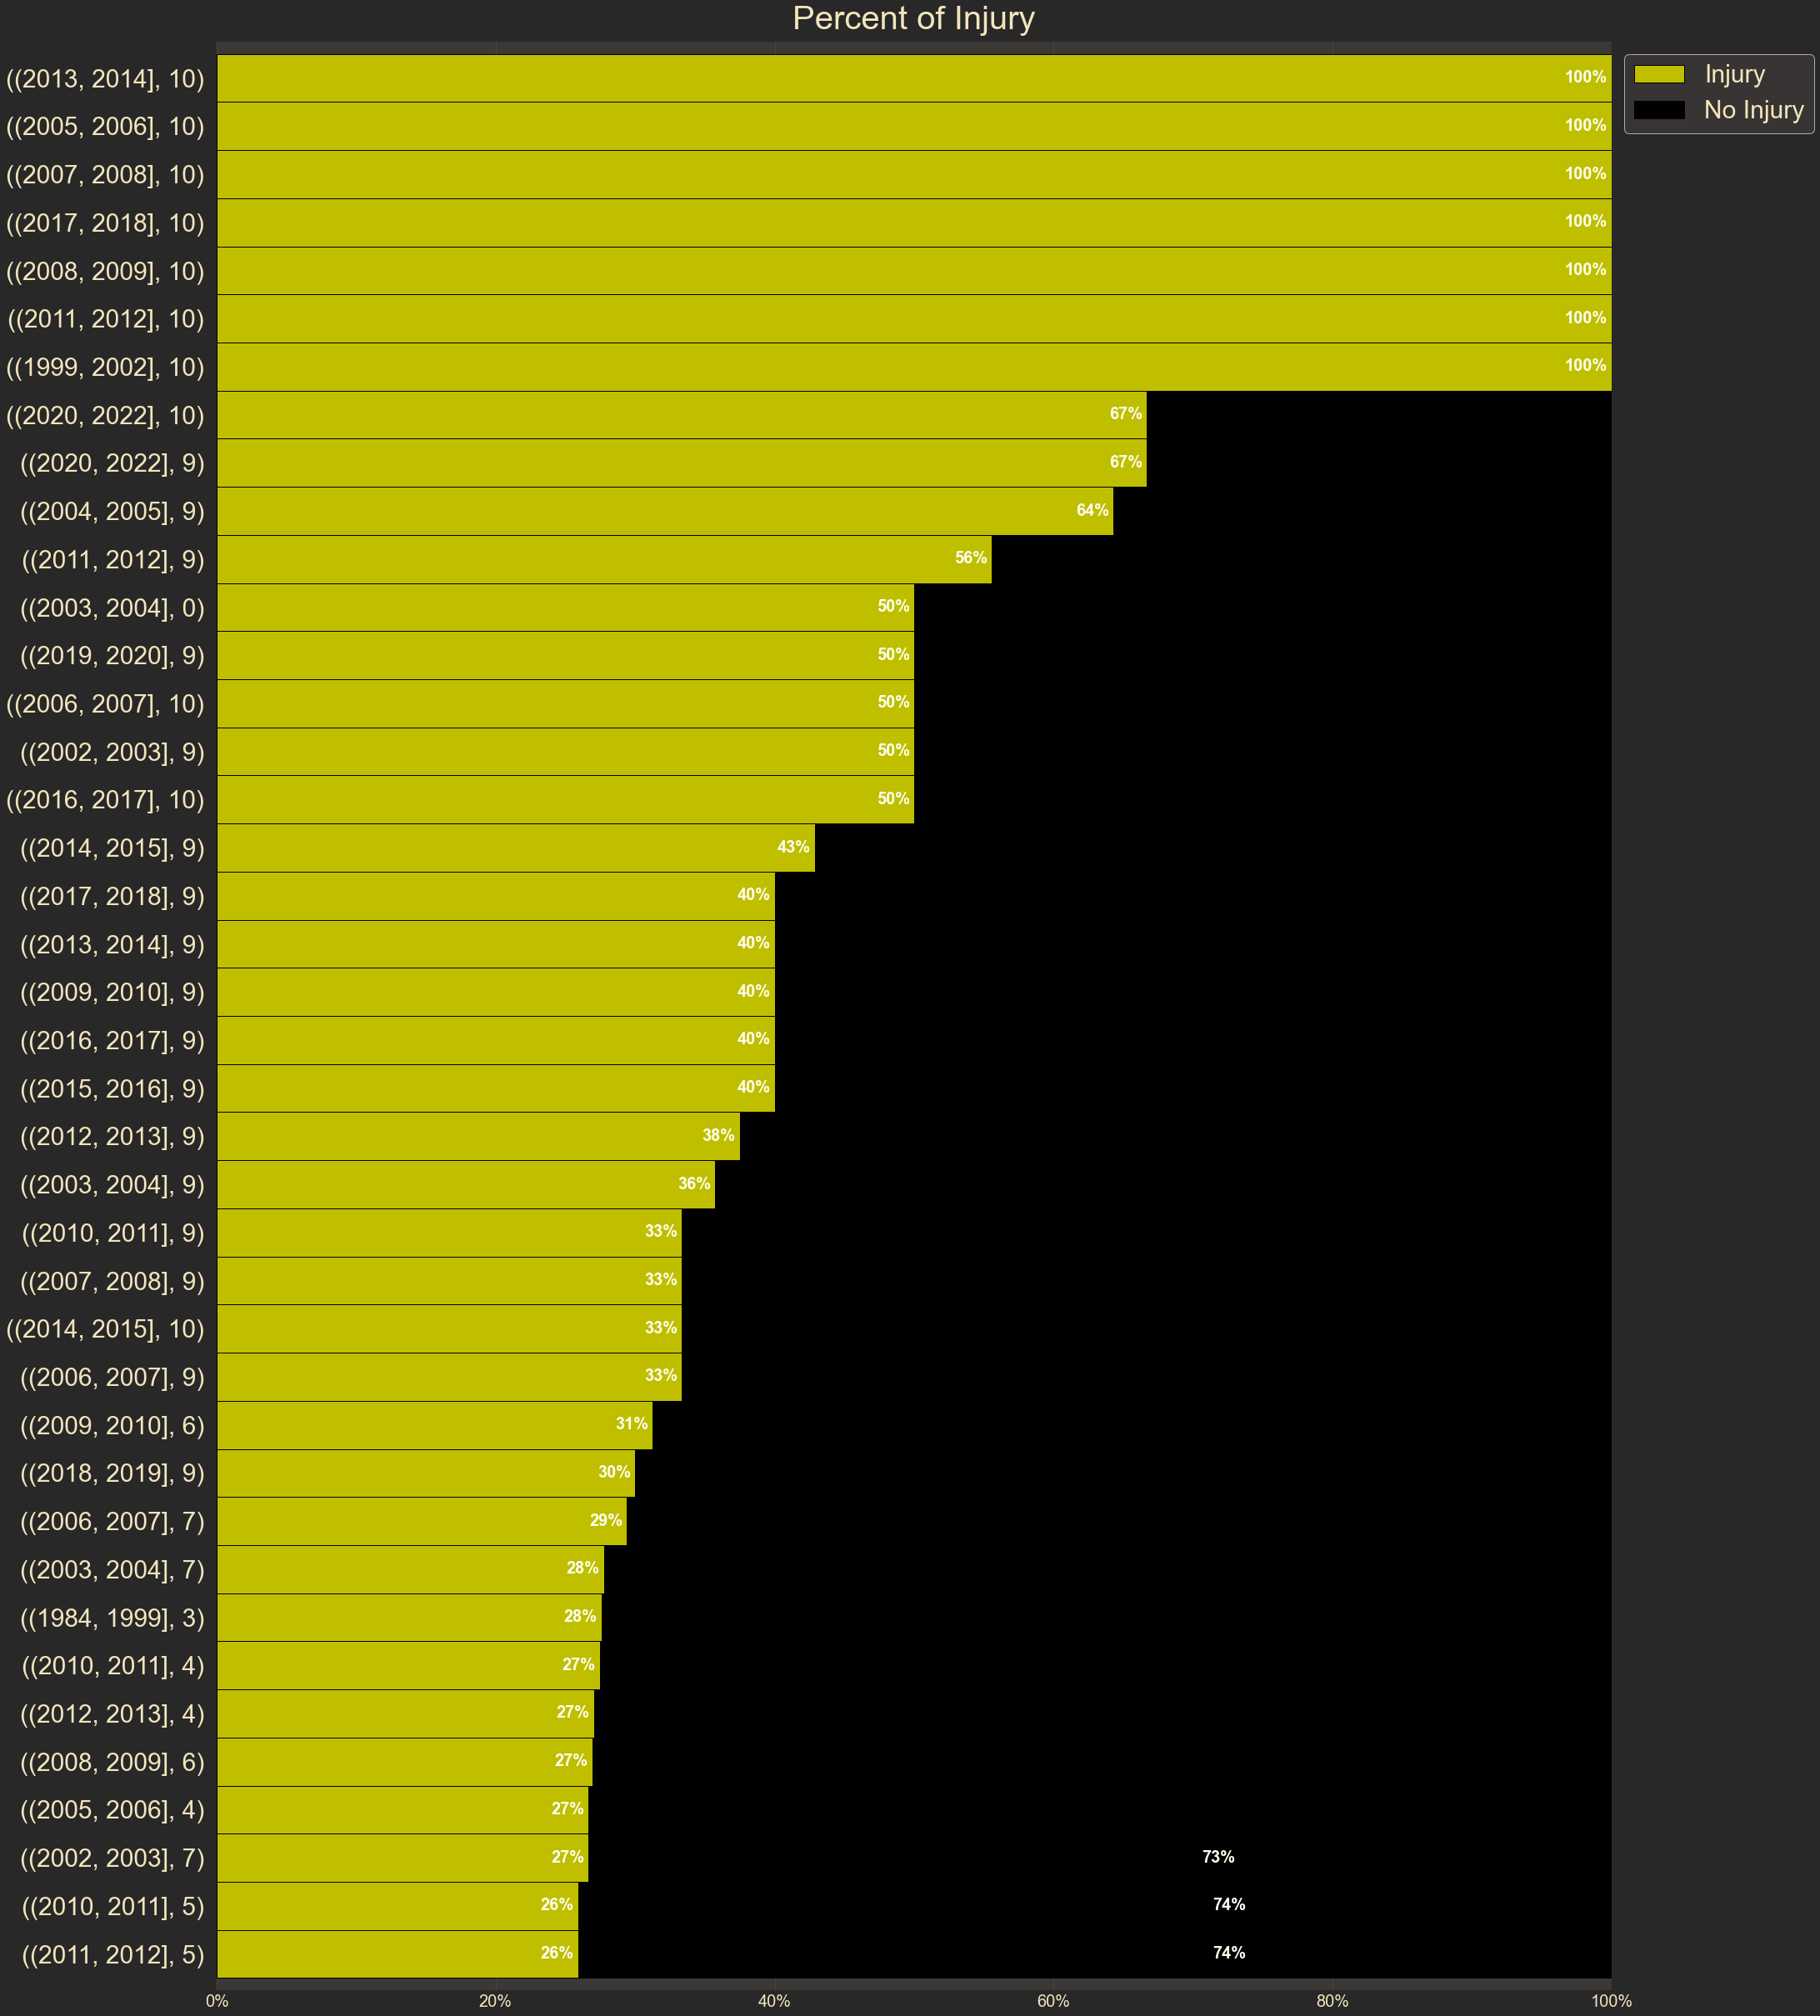

In [37]:
# set ax
fig, ax = plt.subplots(figsize=(30, 43))
# create barplot
bars = injury_pct_df[injury_pct_df.pct_inj > 0.25].sort_values('pct_inj').plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:43]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
# ax.set_yticklabels([re.sub(r'.+\'\((\d)\D+(\d+).+', r'Airbag: \1, Zone: \2', str(x).title()) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=1)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury', fontsize=40, pad=15)
# make it rain
plt.show()